# Structure MCMC - 3 Node DAG Experiments

In [1]:
import os
import random

import numpy as np
import pandas as pd

import arviz as az


import networkx as nx
import matplotlib.pyplot as plt

from scores.ScoreAbstract import Score
from scores.bge import BGEscore, BGEscoreEfficient
from scores.marginal import MarginalLogLikelihood


from cache import Cache

from mcmc.MCMCResultsEngine import MCMCResultsEngine


from evaluation.metrics import *
from utils.graph_utils import *

from proposals.graph.GraphProposal import GraphProposalUniform
from mcmc.StructureMCMC import StructureMCMC

import seaborn as sns
sns.set()


## Generate Data


In [2]:
np.random.seed(3011)
node_labels = ["X1","X2","X3"]

true_DAG_adj = pd.DataFrame(np.array([[0, 1, 0], 
                                      [0, 0, 0], 
                                      [0, 1, 0],
                                      ]), columns=node_labels,index=node_labels)
true_graph = nx.DiGraph(true_DAG_adj)

np.random.seed(42)

# Number of variables
node_labels = list(true_graph.nodes())
num_nodes = len(node_labels)

# Random values between 0 and 1, scaled and shifted to the desired range
max_value = 1.0
min_value = 0.1
random_matrix = np.random.rand(num_nodes, num_nodes) * (max_value - min_value) + min_value

# Random sign of the weights
sampled_values = np.random.choice([-1, 1], size=num_nodes*num_nodes, replace=True)

# Generate the weights matrix, non zero values indicate betas
W_mat = true_DAG_adj.values * random_matrix * sampled_values.reshape(num_nodes,num_nodes) + np.eye(num_nodes)

# function that generates data based on the covariance matrix
def generate_data(num_obs: int, W_mat: np.ndarray, node_labels: list, max_noise: float = 1.0):
    
    num_nodes = len(node_labels)
    
    # Generate the diagonal conditional variance matrix, diagonal values indicate sigma^2_j
    D_mat = np.eye(num_nodes) * np.random.uniform(0.1, max_noise, num_nodes)

    # Covariance matrix 
    Sigma = np.linalg.pinv(W_mat.T) @ D_mat @ np.linalg.pinv(W_mat)

    # Generate data from MVN distribution
    data = multivariate_normal.rvs(cov=Sigma, size=num_obs)
    
    return pd.DataFrame(data, columns=node_labels)

data = generate_data(100, W_mat, node_labels)
data

,X1,X2,X3
0,0.119351,-0.155397,-0.242816
1,0.255835,0.178692,0.030586
2,-0.350140,-0.149289,0.100405
3,-0.608090,0.052670,-0.293280
4,0.002011,2.817305,-0.537259
...,...,...,...
95,-0.643218,-1.629985,0.059389
96,0.196046,1.721165,0.055796
97,-0.370779,1.888922,-1.545127
98,0.622666,-0.643787,0.147888


## Generate True Posterior Distribution

In [3]:
#my_score_str = "BGe Score"
my_score_str = "Dummy Score"
#my_score_str = "Marginal Log Likelihood"
all_dags, total_score = generate_all_dags( data, my_score = my_score_str )
true_posterior_distribution = compute_true_distribution( all_dags )

Total 3 node DAGs generated = 25


In [12]:
all_dags.items() 

dict_items([('000,000,000', {'DAG': <networkx.classes.digraph.DiGraph object at 0x2aafdc1d0>, 'DAG_indx': 0, 'Freq': 1, 'num_orderings': 6, 'num_edges': 0, 'log_score': 1, 'log_score_ordering': 1, 'log_score_ordering_scaled': 0, 'log_score_scaled': 0, 'score_ordering': 6.0, 'score': 1.0, 'score_normalised': 0.04, 'score_ordering_normalised': 0.14285714285714285, 'num_orderings_normalised': 1.0}), ('010,000,000', {'DAG': <networkx.classes.digraph.DiGraph object at 0x2aaff77d0>, 'DAG_indx': 1, 'Freq': 1, 'num_orderings': 2, 'num_edges': 1, 'log_score': 1, 'log_score_ordering': 1, 'log_score_ordering_scaled': 0, 'log_score_scaled': 0, 'score_ordering': 2.0, 'score': 1.0, 'score_normalised': 0.04, 'score_ordering_normalised': 0.047619047619047616, 'num_orderings_normalised': 0.3333333333333333}), ('001,000,000', {'DAG': <networkx.classes.digraph.DiGraph object at 0x2ab014050>, 'DAG_indx': 2, 'Freq': 1, 'num_orderings': 2, 'num_edges': 1, 'log_score': 1, 'log_score_ordering': 1, 'log_score_

{'000,000,000': 0.04, '010,000,000': 0.04, '001,000,000': 0.04, '000,100,000': 0.04, '000,001,000': 0.04, '000,000,100': 0.04, '000,000,010': 0.04, '011,000,000': 0.04, '010,001,000': 0.04, '010,000,100': 0.04, '010,000,010': 0.04, '001,100,000': 0.04, '001,001,000': 0.04, '001,000,010': 0.04, '000,101,000': 0.04, '000,100,100': 0.04, '000,100,010': 0.04, '000,001,100': 0.04, '000,000,110': 0.04, '011,001,000': 0.04, '011,000,010': 0.04, '010,000,110': 0.04, '001,101,000': 0.04, '000,101,100': 0.04, '000,100,110': 0.04}


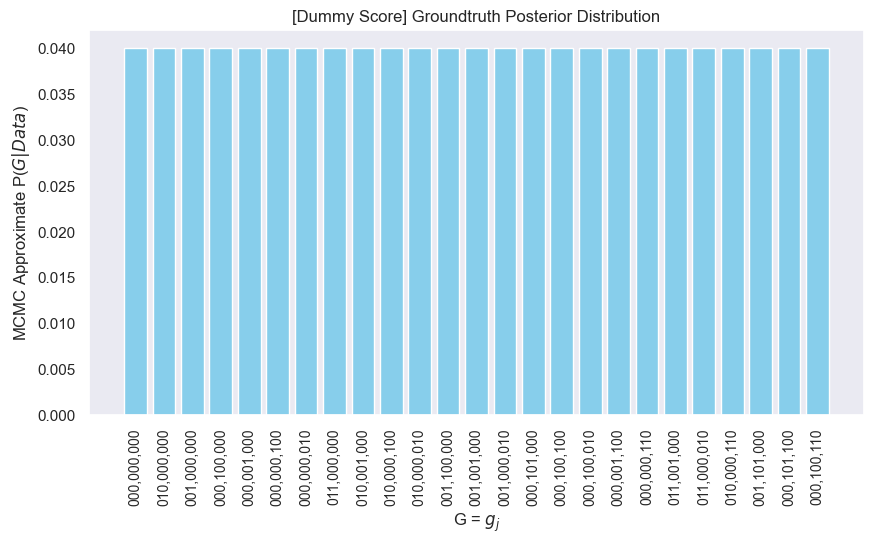

In [13]:
#my_score_str = "BGe Score"
plot_true_posterior_distribution( all_dags, score = 'score_normalised', figsize=(10, 5), 
                                    prob_threshold = 0, 
                                    title = f"[{my_score_str}] Groundtruth Posterior Distribution" )

In [22]:
true_posterior_distribution

{'000,000,000': 0.04,
 '010,000,000': 0.04,
 '001,000,000': 0.04,
 '000,100,000': 0.04,
 '000,001,000': 0.04,
 '000,000,100': 0.04,
 '000,000,010': 0.04,
 '011,000,000': 0.04,
 '010,001,000': 0.04,
 '010,000,100': 0.04,
 '010,000,010': 0.04,
 '001,100,000': 0.04,
 '001,001,000': 0.04,
 '001,000,010': 0.04,
 '000,101,000': 0.04,
 '000,100,100': 0.04,
 '000,100,010': 0.04,
 '000,001,100': 0.04,
 '000,000,110': 0.04,
 '011,001,000': 0.04,
 '011,000,010': 0.04,
 '010,000,110': 0.04,
 '001,101,000': 0.04,
 '000,101,100': 0.04,
 '000,100,110': 0.04}

## Run Structure MCMC

### Starting with an empty DAG

In [5]:
G_init = nx.DiGraph()

G_init.add_node('X1')
G_init.add_node('X2')

G_init.add_node('X3')

#G_init.add_edge("X1", "Y")
#G_init.add_edge("X2", "Y")
#G_init.add_edge("X2", "X3")

results_analyser = MCMCResultsEngine( )

In [6]:
mcmc_cache = Cache()

burnIn = 0

In [7]:

# Initialize the directed graph with the given nodes
#G_init = nx.DiGraph()
#G_init.add_nodes_from(['X1', 'X2', 'X3', 'Y'])

# Define the edge list
#edges_white = [("X1", "X3")]
#edges_black = [("X1", "X2")]


#black_list = edges_to_adjacency_matrix(edges_black, G_init)
#white_list = edges_to_adjacency_matrix(edges_white, G_init)

#white_list


In [8]:
proposal_object = GraphProposalUniform(G_init, whitelist=None, blacklist=None)

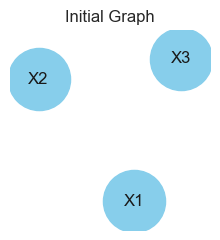

In [9]:
plot_graph(G_init, title="Initial Graph", figsize=(2, 2))

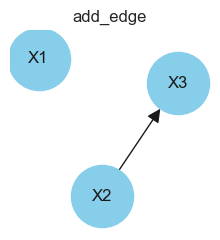

G_Curr neighbours:  7.0


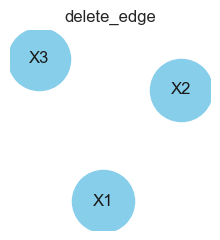

G_Curr neighbours:  7.0


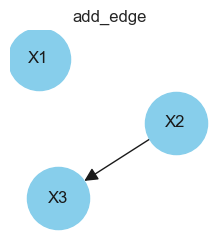

G_Curr neighbours:  7.0


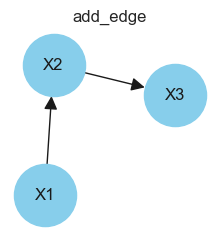

G_Curr neighbours:  7.0


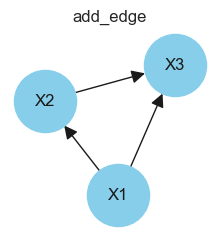

G_Curr neighbours:  6.0


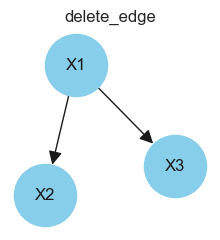

In [10]:
# make one step
G_prop, operation = proposal_object.propose_DAG()
proposal_object.update_G_curr(G_prop)
plot_graph(G_prop, title=operation, figsize=(2, 2))

for i in range(0, 5):
    print("G_Curr neighbours: ", proposal_object.get_G_curr_neigh())
    G_prop, operation = proposal_object.propose_DAG()
    proposal_object.update_G_curr(G_prop)
    plot_graph(G_prop, title=operation, figsize=(2, 2))

In [18]:
from scores.dummy import DummyScore


initial_graph = G_init
initial_order = random.choice(all_valid_orderings(initial_graph))
max_iter = 50000

N = len( data.columns )

proposal_object = GraphProposalUniform(initial_graph, whitelist=None, blacklist=None)
score_object = DummyScore( data=data, graph=initial_graph )
#score_object = BGEscoreEfficient( data=data, graph=initial_graph )
#score_object = MarginalLogLikelihood( data=data, graph=initial_graph )

struct_mcmc = StructureMCMC(initial_graph, max_iter, proposal_object, score_object, burnIn)

mcmc_res, accept_rate = struct_mcmc.run()
print(f"ACCEPTANCE RATE = {accept_rate}")

ACCEPTANCE RATE = 0.9628


In [19]:
# compute the approximate posterior distribution
# test
graph_list = struct_mcmc.get_mcmc_res_graphs( mcmc_res )[burnIn:]

result_index = {key: 0 for key in true_posterior_distribution.keys()}
approx_posterior_distribution = update_graph_frequencies(graph_list, result_index)


{'010,000,000', '000,000,010', '011,000,010', '010,000,100', '000,100,010', '000,000,000', '011,001,000', '010,000,010', '000,101,000', '010,001,000', '000,001,100', '011,000,000', '000,100,110', '000,100,100', '000,000,110', '000,101,100', '000,000,100', '001,000,010', '000,001,000', '001,001,000', '000,100,000', '010,000,110', '001,101,000', '001,000,000', '001,100,000'}


In [20]:
jensen_shannon_divergence( true_posterior_distribution, approx_posterior_distribution )

0.017672821566294048

In [14]:
jensen_shannon_divergence( true_posterior_distribution, approx_posterior_distribution )

0.014817223794602293

In [15]:
jensen_shannon_divergence( true_posterior_distribution, approx_posterior_distribution )

0.014817223794602293

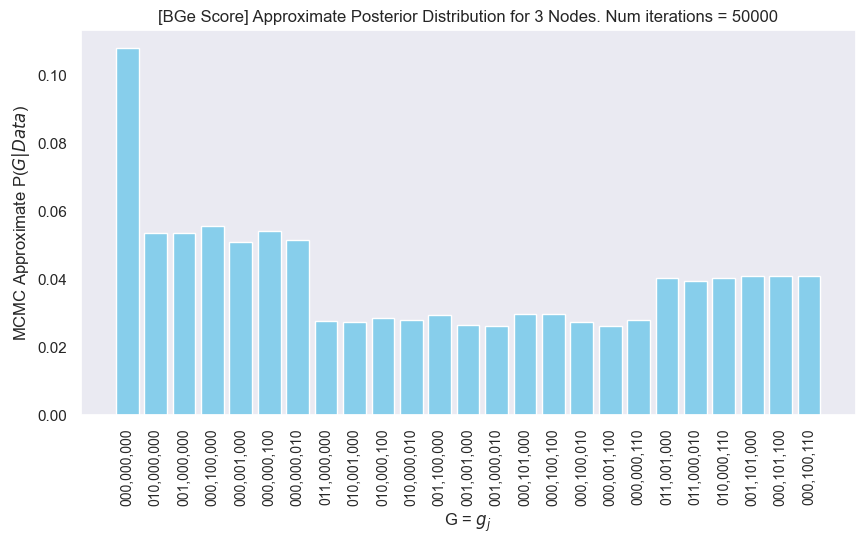

In [21]:
appr_mapper = plot_approx_posterior_distribution(approx_posterior_distribution,  prob_threshold = 0, title = f'[{score_object.to_string}] Approximate Posterior Distribution for {len(data.columns)} Nodes. Num iterations = {max_iter}', figsize=(10, 5))


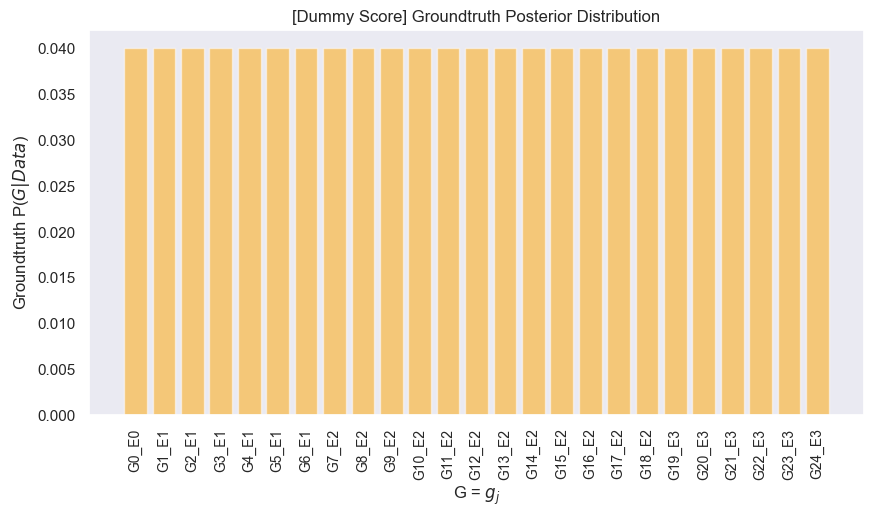

In [17]:
prob_threshold = 0
filtered_dags = {k: v for k, v in all_dags.items() if v['score_normalised'] >= prob_threshold}
        
fig, ax = plt.subplots(figsize=(10, 5))
mapper = plot_true_posterior_distribution( filtered_dags, 
                                        score = 'score_normalised', #figsize=(15, 7), 
                                        prob_threshold = prob_threshold, 
                                        title = f"[{my_score_str}] Groundtruth Posterior Distribution", 
                                        alpha=0.5, my_color = 'orange',  ax=ax )